In [158]:
import torch
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
import math
from torch import nn

In [159]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

custom_style = mp_drawing_styles.get_default_pose_landmarks_style()
custom_connections = list(mp_pose.POSE_CONNECTIONS)

In [160]:
image_path = '/Users/rushirajgadhvi/Downloads/WhatsApp Image 2023-10-04 at 11.23.03 AM.jpeg'
image = cv2.imread(image_path)

# Convert the image to RGB (MediaPipe requires RGB input)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

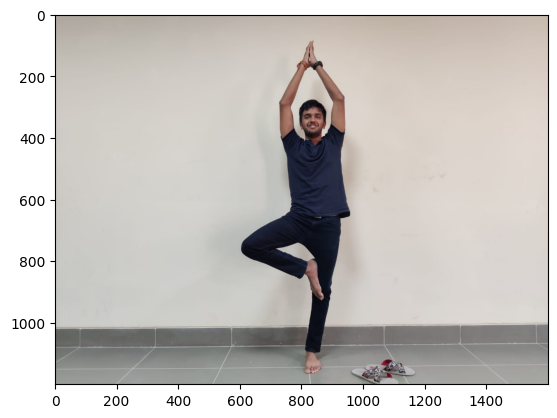

In [161]:
plt.imshow(image_rgb)

In [162]:
def detect(img):

    data = []
    # Create a Pose object
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Process the image to detect body pose
        results = pose.process(img)

        if results.pose_landmarks:
            # Draw the landmarks on the image
            mp_drawing.draw_landmarks(
                img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
            # Save the landmarks in a DataFrame
            for landmark in results.pose_landmarks.landmark:
                data += [landmark.x, landmark.y, landmark.z, landmark.visibility]

    return img, data

In [163]:
def angle(self, point1, point2, point3):
    """ Calculate angle between two lines """
    if(point1==(0,0) or point2==(0,0) or point3==(0,0)):
        return 0
    numerator = point2[1] * (point1[0] - point3[0]) + point1[1] * \
                (point3[0] - point2[0]) + point3[1] * (point2[0] - point1[0])
    denominator = (point2[0] - point1[0]) * (point1[0] - point3[0]) + \
                (point2[1] - point1[1]) * (point1[1] - point3[1])
    try:
        ang = math.atan(numerator/denominator)
        ang = ang * 180 / math.pi
        if ang < 0:
            ang = 180 + ang
        return ang
    except:
        return 90.0

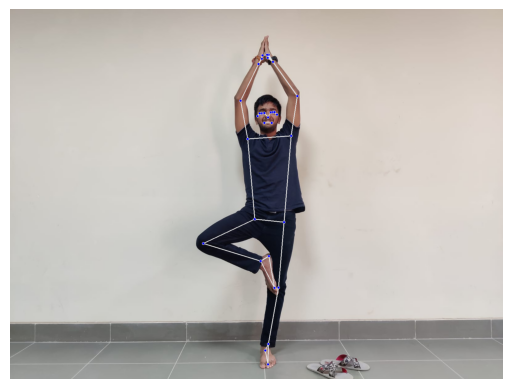

In [164]:
img, data = detect(image_rgb)
plt.imshow(img)
plt.axis('off')
plt.show()

In [165]:
body_pose_landmarks = ["nose","left eye inner","left eye","left eye outer",
                        "right eye inner","right eye","right eye outer",
                        "left ear","right ear","mouth left","mouth right",
                        "left shoulder","right shoulder","left elbow",
                        "right elbow","left wrist","right wrist","left pinky",
                        "right pinky","left index","right index","left thumb",
                        "right thumb","left hip","right hip","left knee",
                        "right knee","left ankle","right ankle","left heel",
                        "right heel", "left foot index","right foot index"]

col_name = []
for i in body_pose_landmarks:
    col_name += [i + ' X', i + ' Y', i + ' Z', i + ' V']

# rename columns
final_df = pd.DataFrame(columns=col_name)
final_df.loc[0] = data

In [166]:
final_df = final_df[final_df.columns[~final_df.columns.str.contains(' V')]]

In [167]:
'''
f1: angle between left shoulder, left elbow, left wrist
f2: angle between right shoulder, right elbow, right wrist
f3: angle between left shoulder, left hip, left knee
f4: angle between right shoulder, right hip, right knee
f5: angle between left hip, left knee, left ankle
f6: angle between right hip, right knee, right ankle
f7: angle between nose, left shoulder, left hip
f8: angle between nose, right shoulder, right hip
f9: angle between left shoulder, nose, right shoulder
f10: angle between left knee, left ankle, left foot index
f11: angle between right knee, right ankle, right foot index
f12: angle between left index, left wrist, left thumb
f13: angle between right index, right wrist, right thumb
f14: angle between left shoulder, left hip, left foot index
f15: angle between right shoulder, right hip, right foot index
'''

feature_df = pd.DataFrame()

feature_df['f1'] = final_df.apply(lambda x: angle(x, (x['left shoulder X'], x['left shoulder Y']), (x['left elbow X'], x['left elbow Y']), (x['left wrist X'], x['left wrist Y'])), axis=1)
feature_df['f2'] = final_df.apply(lambda x: angle(x, (x['right shoulder X'], x['right shoulder Y']), (x['right elbow X'], x['right elbow Y']), (x['right wrist X'], x['right wrist Y'])), axis=1)
feature_df['f3'] = final_df.apply(lambda x: angle(x, (x['left shoulder X'], x['left shoulder Y']), (x['left hip X'], x['left hip Y']), (x['left knee X'], x['left knee Y'])), axis=1)
feature_df['f4'] = final_df.apply(lambda x: angle(x, (x['right shoulder X'], x['right shoulder Y']), (x['right hip X'], x['right hip Y']), (x['right knee X'], x['right knee Y'])), axis=1)
feature_df['f5'] = final_df.apply(lambda x: angle(x, (x['left hip X'], x['left hip Y']), (x['left knee X'], x['left knee Y']), (x['left ankle X'], x['left ankle Y'])), axis=1)
feature_df['f6'] = final_df.apply(lambda x: angle(x, (x['right hip X'], x['right hip Y']), (x['right knee X'], x['right knee Y']), (x['right ankle X'], x['right ankle Y'])), axis=1)
feature_df['f7'] = final_df.apply(lambda x: angle(x, (x['nose X'], x['nose Y']), (x['left shoulder X'], x['left shoulder Y']), (x['left hip X'], x['left hip Y'])), axis=1)
feature_df['f8'] = final_df.apply(lambda x: angle(x, (x['nose X'], x['nose Y']), (x['right shoulder X'], x['right shoulder Y']), (x['right hip X'], x['right hip Y'])), axis=1)
feature_df['f9'] = final_df.apply(lambda x: angle(x, (x['left shoulder X'], x['left shoulder Y']), (x['nose X'], x['nose Y']), (x['right shoulder X'], x['right shoulder Y'])), axis=1)
feature_df['f10'] = final_df.apply(lambda x: angle(x, (x['left knee X'], x['left knee Y']), (x['left ankle X'], x['left ankle Y']), (x['left foot index X'], x['left foot index Y'])), axis=1)
feature_df['f11'] = final_df.apply(lambda x: angle(x, (x['right knee X'], x['right knee Y']), (x['right ankle X'], x['right ankle Y']), (x['right foot index X'], x['right foot index Y'])), axis=1)
feature_df['f12'] = final_df.apply(lambda x: angle(x, (x['left index X'], x['left index Y']), (x['left wrist X'], x['left wrist Y']), (x['left thumb X'], x['left thumb Y'])), axis=1)
feature_df['f13'] = final_df.apply(lambda x: angle(x, (x['right index X'], x['right index Y']), (x['right wrist X'], x['right wrist Y']), (x['right thumb X'], x['right thumb Y'])), axis=1)
feature_df['f14'] = final_df.apply(lambda x: angle(x, (x['left shoulder X'], x['left shoulder Y']), (x['left hip X'], x['left hip Y']), (x['left foot index X'], x['left foot index Y'])), axis=1)
feature_df['f15'] = final_df.apply(lambda x: angle(x, (x['right shoulder X'], x['right shoulder Y']), (x['right hip X'], x['right hip Y']), (x['right foot index X'], x['right foot index Y'])), axis=1)

In [168]:
feature_df

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
0,17.047437,165.780456,179.939438,158.565573,178.121606,63.802579,143.637003,29.719544,52.259921,1.74362,162.197427,158.627563,10.966806,179.138551,3.830741


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 25)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(25, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

In [ ]:
input_size = 15  
num_classes = 6  

model = SimpleNN(input_size, num_classes)

checkpoint = torch.load('/Users/rushirajgadhvi/Desktop/mlpr/project/model.pth')
model.load_state_dict(checkpoint)
model.eval()

SimpleNN(
  (fc1): Linear(in_features=15, out_features=25, bias=True)
  (relu1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
input_data = torch.tensor(feature_df.values, dtype=torch.float32)
target_names = ['tree','cobra','downdog_data','goddess','warrior','chair']

# Make predictions
with torch.no_grad():
    pred = model(input_data)
    print(pred)

# Get predicted class
pred_idx = torch.argmax(pred, dim=1)
print(pred_idx[0], target_names[pred_idx])

tensor([[1.0000e+00, 1.1021e-35, 0.0000e+00, 5.3670e-22, 4.1552e-15, 7.4983e-13]])
tensor(0) tree
